**Decision Tree**

In [1]:
!pip install mne

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 21.9 MB/s eta 0:00:00


In [2]:
import numpy as np

In [3]:
# Load the data from drive
data_array = np.load('/content/drive/My Drive/data_array.npy')
label_array = np.load('/content/drive/My Drive/label_array.npy')
group_array = np.load('/content/drive/My Drive/group_array.npy')
features_array = np.load('/content/drive/My Drive/features_array.npy')

print(data_array.shape, label_array.shape, group_array.shape,features_array.shape)

(6843, 19, 1250) (6843,) (6843,) (6843, 551)


# ML Model

In [4]:
!pip install scikit-learn

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, GroupKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

In [7]:
# Define Decision Tree classifier
dt = DecisionTreeClassifier(random_state=42)

# Define Group K-Fold
gkf = GroupKFold(n_splits=5)

# Define pipeline (scaling + Decision Tree)
pipe = Pipeline([
    ('scaler', StandardScaler()),  # Scale features for better performance
    ('dt', dt)
])

# Define hyperparameter grid
param_grid = {
    'dt__criterion': ['entropy'],  # Split criterion
    'dt__max_depth': [5, 10, 15],  # Control tree depth
    'dt__min_samples_split': [5, 10],  # Minimum samples per split
    'dt__min_samples_leaf': [2, 5, 10]  # Minimum samples per leaf
}

# Perform Grid Search with GroupKFold Cross-Validation
gscv = GridSearchCV(pipe, param_grid, cv=gkf, n_jobs=12, verbose=1)

# Train model
gscv.fit(features_array, label_array, groups=group_array)
best_model = gscv.best_estimator_


Fitting 5 folds for each of 18 candidates, totalling 90 fits


In [8]:
# Print best parameters and score
print("Best Parameters:", gscv.best_params_)
print("Best Score:", gscv.best_score_)

Best Parameters: {'dt__criterion': 'entropy', 'dt__max_depth': 10, 'dt__min_samples_leaf': 5, 'dt__min_samples_split': 5}
Best Score: 0.5533566906072857


# Classification report and Confusion matrix  

Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.57      0.54      3183
           1       0.59      0.53      0.56      3660

    accuracy                           0.55      6843
   macro avg       0.55      0.55      0.55      6843
weighted avg       0.55      0.55      0.55      6843



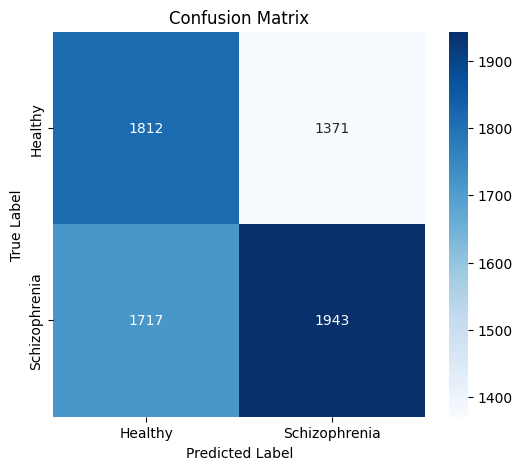

In [10]:
# Initialize arrays for storing results
y_true_all = []
y_pred_all = []

# Perform GroupKFold cross-validation manually with the best model
for train_idx, test_idx in gkf.split(features_array, label_array, groups=group_array):
    # Split data
    X_train, X_test = features_array[train_idx], features_array[test_idx]
    y_train, y_test = label_array[train_idx], label_array[test_idx]

    # Fit the best model on training data
    best_model.fit(X_train, y_train)

    # Predict on test data
    y_pred = best_model.predict(X_test)

    # Store true and predicted labels
    y_true_all.extend(y_test)
    y_pred_all.extend(y_pred)

# Convert lists to numpy arrays
y_true_all = np.array(y_true_all)
y_pred_all = np.array(y_pred_all)

# Compute classification report
print("Classification Report:")
print(classification_report(y_true_all, y_pred_all))

# Compute confusion matrix
cm = confusion_matrix(y_true_all, y_pred_all)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Healthy", "Schizophrenia"], yticklabels=["Healthy", "Schizophrenia"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()